In [1]:
import os
import zipfile
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, row_number, lower, regexp_replace, lpad, rpad, concat, rank
from pyspark.sql.window import Window
import pandas as pd
import time
import matplotlib.pyplot as plt
import requests

## Downloading zip files

In [2]:
! wget https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip

--2023-04-03 13:34:39--  https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip’

hdma-wi-2021.zip    100%[===================>]  20.50M  15.3MB/s    in 1.3s    

2023-04-03 13:34:41 (15.3 MB/s) - ‘hdma-wi-2021.zip’ saved [21494278/21494278]



In [3]:
! wget https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip

--2023-04-03 13:34:41--  https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144804 (141K) [application/zip]
Saving to: ‘arid2017_to_lei_xref_csv.zip’

arid2017_to_lei_xre 100%[===================>] 141.41K  --.-KB/s    in 0.07s   

2023-04-03 13:34:41 (1.88 MB/s) - ‘arid2017_to_lei_xref_csv.zip’ saved [144804/144804]



In [4]:
! wget https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip

--2023-04-03 13:34:41--  https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 798030 (779K) [application/zip]
Saving to: ‘code_sheets.zip’

code_sheets.zip     100%[===================>] 779.33K  --.-KB/s    in 0.1s    

2023-04-03 13:34:42 (5.11 MB/s) - ‘code_sheets.zip’ saved [798030/798030]



In [5]:
# function to list files with a certain extension like csv and zip
def getFiles(ext, folder):
    folder = os.listdir(folder)
    wanted = []
    for file in folder:
        if file.endswith(ext):
            wanted.append(file)
    return wanted

In [6]:
zips = getFiles("zip", ".")
zips

['arid2017_to_lei_xref_csv.zip', 'hdma-wi-2021.zip', 'code_sheets.zip']

## Extracting zip files

In [7]:
for file in zips:
    with zipfile.ZipFile(file, "r") as unzipper:
        unzipper.extractall()

## Starting Spark session and adding files

In [8]:
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/03 13:34:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
sc = spark.sparkContext
sc

<SparkContext master=spark://main:7077 appName=cs544>

### loading loans and banks to Data Warehouse

In [10]:
! hdfs dfs -cp arid2017_to_lei_xref_csv.csv hdfs://main:9000/arid2017_to_lei_xref_csv.csv
! hdfs dfs -cp hdma-wi-2021.csv hdfs://main:9000/hdma-wi-2021.csv

In [11]:
(spark.read.csv(f"hdfs://main:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)
 .write.saveAsTable("banks", mode="overwrite"))


(spark.read.csv(f"hdfs://main:9000/hdma-wi-2021.csv", header=True, inferSchema=True)
 .write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite"))

23/04/03 13:35:34 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/04/03 13:35:34 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/04/03 13:35:39 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/04/03 13:35:39 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.20.0.2
23/04/03 13:35:40 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/04/03 13:35:40 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/04/03 13:35:42 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/banks; Force to delete it.
23/04/03 13:35:42 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/banks
23/04/03 13:35:45 WARN Sessio

### Adding the code sheet files to Data Warehouse

In [12]:
select = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason"
          , "loan_type", "loan_purpose", "preapproval", "property_type"]
files = getFiles("csv", ".")
for file in files:
    if file[0:file.find(".")] in select:
        ! hdfs dfs -cp {file} hdfs://main:9000/{file}
        (spark.read.csv(f"hdfs://main:9000/{file}", header=True, inferSchema=True)
         .createOrReplaceTempView(file[0:file.find(".")]))

### Q1: what tables are in our warehouse?

In [13]:
#Q1
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



In [14]:
#getting rid of excess files
! rm *.csv

In [15]:
! rm *.zip

### Q2: how many banks contain the word "first" in their name? Which ones contain "second"?

In [16]:
banks = spark.table("banks")

In [17]:
banks.limit(10).toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,First National Bank,110004,5493003EW6T31TGECO83,5493003EW6T31TGECO83,5493003EW6T31TGECO83
1,"First Mid Bank & Trust, National Association",110045,549300XOTES5TCS8T794,549300XOTES5TCS8T794,549300XOTES5TCS8T794
2,"First Hope Bank, A National Banking Association",110118,5493003XLOX5FDT9R120,5493003XLOX5FDT9R120,5493003XLOX5FDT9R120
3,First National Bank of Waterloo,110180,5493002GOGIUXB84JB89,5493002GOGIUXB84JB89,5493002GOGIUXB84JB89
4,Cumberland Valley National Bank & Trust Company,110254,549300OULGV8ZW0JV320,549300OULGV8ZW0JV320,549300OULGV8ZW0JV320
5,The Lyons National Bank,11027,254900Q6IHGQO7INVC79,254900Q6IHGQO7INVC79,254900Q6IHGQO7INVC79
6,"Midstates Bank, National Association",110354,2549002IXACRD1HE6A92,2549002IXACRD1HE6A92,2549002IXACRD1HE6A92
7,First National Bank of North Arkansas,110406,5493000LJB0L73TDJT41,5493000LJB0L73TDJT41,5493000LJB0L73TDJT41
8,"First National Bank, Ames, Iowa",110408,549300OIJZOV6CPR1Y57,549300OIJZOV6CPR1Y57,549300OIJZOV6CPR1Y57
9,"Texas Gulf Bank, National Association",110420,54930031J0Z4IG9PQZ65,54930031J0Z4IG9PQZ65,None


#### banks with first in their name

In [18]:
#Q2
#part1
banks.where(lower(col('respondent_name')).contains("first")).count()

525

In [19]:
#Q2
#part2
(banks.select(col('respondent_name').alias("Banks With Second"))
 .where(lower(col("Banks With Second")).contains("second"))).toPandas()

,Banks With Second
0,Old Second National Bank


### Q3: how many loan applications has your "favorite" bank received in the dataset?

Our favorite bank is Associated Bank

In [21]:
loans = spark.table("loans")

Checking to see if my favorite bank is in the dataset 

In [22]:
#Q3
results = (banks
 .join(loans, on= banks["lei_2020"] == loans["lei"], how="INNER")
 .filter(banks["respondent_name"] == "Associated Bank, National Association")
 )

results.count()

15024

### Q4: what does results.explain("formatted") tell us about Spark's query plan for Q3?

In [23]:
#Q4
results.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildLeft (6)
   :- BroadcastExchange (3)
   :  +- Filter (2)
   :     +- Scan parquet default.banks (1)
   +- Filter (5)
      +- Scan parquet default.loans (4)


(1) Scan parquet default.banks
Output [5]: [respondent_name#947, arid_2017#948, lei_2018#949, lei_2019#950, lei_2020#951]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,Associated Bank, National Association), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,arid_2017:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [5]: [respondent_name#947, arid_2017#948, lei_2018#949, lei_2019#950, lei_2020#951]
Condition : ((isnotnull(respondent_name#947) AND (respondent_name#947 = Associated Bank, National Association)) AND isnotnull(lei_2020#951))

(3) BroadcastExchange
Input [5]: [respondent_name#947, arid_2017#948, lei_201

In [24]:
#Q4
# 1) We can see that our banks table is inputed into Broadcast Exchange because the Input Columns correspond to the column names belonging to Banks 
# 2) We can see two filtering steps in the plan, one for both tables. the condition "isnotnull" is first ran our banks table in step 2
# another filtering step is then ran in step 5 with condition "is not null(lei)". 
# 3) Our Plan does NOT involve a Hash Aggregate in the Spark Plan

In [25]:
counties = spark.table("counties").distinct()

fixed_counties = (spark.table("counties").select(counties.NAME, counties.STATE, counties.COUNTY, rpad(counties.STATE, 2, '0').alias("state1")
                              , lpad(counties.COUNTY, 3, '0').alias("county1"))
 .select(col("NAME"), concat(col("state1"), col("county1")).alias('county_code')))

fixed_counties.limit(10).toPandas()

,NAME,county_code
0,North Slope,20185
1,Yukon-Koyukuk,20290
2,Northwest Arctic,20188
3,Nome,20180
4,Nome,20180
5,Southeast Fairbanks,20240
6,Nome,20180
7,Fairbanks North Star,20090
8,Nome,20180
9,Denali,20068


### Q5: what are the top 10 biggest loans (in terms of loan_amount) that were approved by your favorite bank?

In [26]:
action_taken = spark.table("action_taken")
loan_purpose = spark.table("loan_purpose")

#getting a fixed counties table which fixes issues of 0's in countycodes and concats state and county
fixed_counties = (spark.table("counties").select(counties.NAME, counties.STATE, counties.COUNTY, rpad(counties.STATE, 2, '0').alias("state1")
                              , lpad(counties.COUNTY, 3, '0').alias("county1"))
 .select(col("NAME"), concat(col("state1"), col("county1")).alias('county_code')))

#computing the answer to q5
q5 = (loans.join(loan_purpose, loans["loan_purpose"] == loan_purpose["id"], how = "left")
     .join(action_taken, loans["action_taken"] == action_taken["id"], how = "left")
     .join(banks, loans["lei"] == banks["lei_2020"], how = "left")
     .join(fixed_counties, loans["county_code"] == fixed_counties["county_code"])
     .select(loans.census_tract, fixed_counties.NAME , loan_purpose.loan_purpose, loans.derived_dwelling_category
             , loans.interest_rate, (loans.loan_amount/1000).alias("thousands")
             , (loans.loan_term/12).alias("years"), action_taken.action_taken)
     .where(banks.respondent_name == "Associated Bank, National Association")
     .where(action_taken.action_taken == "Loan originated")
     .orderBy(col("thousands").desc()))

In [27]:
q5.limit(10).toPandas()

,census_tract,NAME,loan_purpose,derived_dwelling_category,interest_rate,thousands,years,action_taken
0,55079130200,Milwaukee,None,Multifamily:Site-Built,2.06,27835.0,10.0,Loan originated
1,55133204302,Waukesha,Home purchase,Multifamily:Site-Built,2.49,27255.0,3.0,Loan originated
2,55101001701,Racine,Home purchase,Multifamily:Site-Built,2.35,25885.0,5.0,Loan originated
3,55079130200,Milwaukee,Home purchase,Multifamily:Site-Built,2.75,20425.0,3.0,Loan originated
4,55133201101,Waukesha,Home purchase,Multifamily:Site-Built,3.25,20255.0,3.0,Loan originated
5,55087010100,Outagamie,Home purchase,Multifamily:Site-Built,3.75,14245.0,2.0,Loan originated
6,55133200201,Waukesha,None,Multifamily:Site-Built,2.36,13005.0,10.0,Loan originated
7,55079003400,Milwaukee,None,Multifamily:Site-Built,2.75,9535.0,5.0,Loan originated
8,55079185100,Milwaukee,None,Multifamily:Site-Built,2.75,9315.0,5.0,Loan originated
9,55139001600,Winnebago,None,Multifamily:Site-Built,3.25,9305.0,7.0,Loan originated


### Q6: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?

In [28]:
loans.groupby(col('lei')).avg('loan_amount').explain('formatted')

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [lei#970, loan_amount#990]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,loan_amount:double>

(2) HashAggregate
Input [2]: [lei#970, loan_amount#990]
Keys [1]: [lei#970]
Functions [1]: [partial_avg(loan_amount#990)]
Aggregate Attributes [2]: [sum#2502, count#2503L]
Results [3]: [lei#970, sum#2504, count#2505L]

(3) Exchange
Input [3]: [lei#970, sum#2504, count#2505L]
Arguments: hashpartitioning(lei#970, 200), ENSURE_REQUIREMENTS, [plan_id=1056]

(4) HashAggregate
Input [3]: [lei#970, sum#2504, count#2505L]
Keys [1]: [lei#970]
Functions [1]: [avg(loan_amount#990)]
Aggregate Attributes [1]: [avg(loan_amount#990)#2498]
Results [2]: [lei#970, avg(loan_amount#990)#2498 AS avg(loan_amount)#2499]

(5) AdaptiveSparkPlan
Output [2]

In [29]:
loans.groupby(col('county_code')).avg('loan_amount').explain('formatted')

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [county_code#973, loan_amount#990]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,loan_amount:double>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#973, loan_amount#990]
Keys [1]: [county_code#973]
Functions [1]: [partial_avg(loan_amount#990)]
Aggregate Attributes [2]: [sum#2609, count#2610L]
Results [3]: [county_code#973, sum#2611, count#2612L]

(3) HashAggregate
Input [3]: [county_code#973, sum#2611, count#2612L]
Keys [1]: [county_code#973]
Functions [1]: [avg(loan_amount#990)]
Aggregate Attributes [1]: [avg(loan_amount#990)#2605]
Results [2]: [county_code#973, avg(loan_amount#990)#2605 AS avg(loan_amount)#2606]

(4) AdaptiveSparkPlan
Output [2]: [county_code#973, avg(loan_amount)#2606]
Arguments: isFinalPlan

In [30]:
# There exists an exchange step in our lei grouped query, but not our county_code group query
# so when we find the mean aggregate grouping by the lei column, we need network I/O. In spark we initially have arbitrary 
# partitions by default to avoid very large partitions when a certain key dominates. when we group by the lei column we need
# to shuffle/exchange the data so that for any key, all the rows are in the same partition. these partitions may be across
# multiple machines (usually the case in distributed computing) so, we have to trasnfer data across the network
# the when we ran the same query but, grouped by county_code instead, there is no network I/O because we opted to bucket
# our data by the county_code column when loading into hive. So, all rows for any particular county code are already in the
# same partition. 

### Q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications?

In [31]:
#Q7
WellsFargoTopCounties = (loans.join(loan_purpose, loans["loan_purpose"] == loan_purpose["id"], how = "left")
     .join(banks, loans["lei"] == banks["lei_2020"], how = "left")
     .join(fixed_counties, loans["county_code"] == fixed_counties["county_code"])
     .select(fixed_counties.NAME.alias("name"), loans.interest_rate, banks.respondent_name)
     .where(banks.respondent_name == "Wells Fargo Bank, National Association")
     .groupby(col("name"))
     .agg(
         expr("COUNT(*)").alias("loan_count")
        ,expr("AVG(interest_rate)").alias("Average Interest Rate")
     )
     .orderBy(col("loan_count").desc())
     )


q7 = WellsFargoTopCounties.limit(10).toPandas()
q7

,name,loan_count,Average Interest Rate
0,Milwaukee,2164,3.117347
1,Waukesha,1832,2.875823
2,Washington,748,2.851009
3,Dane,729,2.890675
4,Brown,663,3.010949
5,Racine,537,3.099784
6,Outagamie,513,2.979662
7,Winnebago,402,3.028476
8,Ozaukee,389,2.867377
9,Sheboygan,307,2.995511


Text(0, 0.5, 'Average Interest Rate')

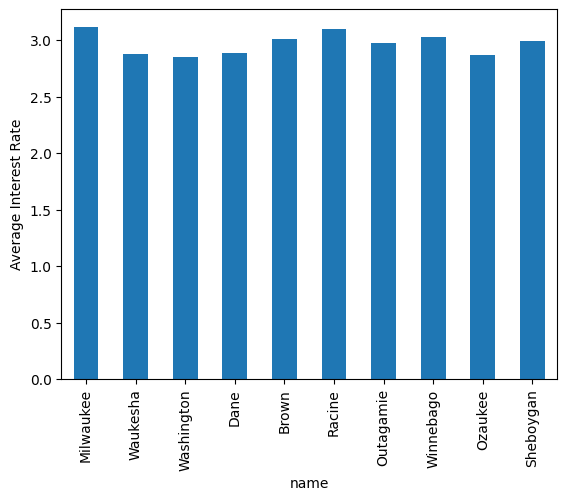

In [32]:
#q7
ax = q7.plot.bar(x="name", y="Average Interest Rate", legend = False)
ax.set_ylabel("Average Interest Rate")

### Q8: what is the second biggest loan application amount in each county? (answer for top 10 counties).

In [33]:
#q8
#referenced following link for windowing in spark: https://www.geeksforgeeks.org/pyspark-window-functions/
windowPartition = Window.partitionBy("name").orderBy(col("2nd Biggest Loan Application (Millions $)").desc())

q8 = (loans.join(fixed_counties, loans["county_code"] == fixed_counties["county_code"])
 .select(counties.NAME.alias("name"), (loans.loan_amount/1000000).alias("2nd Biggest Loan Application (Millions $)"))
 .withColumn("row_num", rank().over(windowPartition))
 .where(col("row_num") == 2)
 .orderBy(col("2nd Biggest Loan Application (Millions $)").desc())
 .limit(10).toPandas())

q8

,name,2nd Biggest Loan Application (Millions $),row_num
0,Kenosha,66.005,2
1,Dane,52.005,2
2,Milwaukee,42.005,2
3,Waukesha,30.005,2
4,Ozaukee,29.915,2
5,Walworth,17.695,2
6,Brown,17.215,2
7,La Crosse,15.955,2
8,Washington,11.705,2
9,Outagamie,10.965,2


Text(0, 0.5, '2nd Biggest Loan Application (Millions $)')

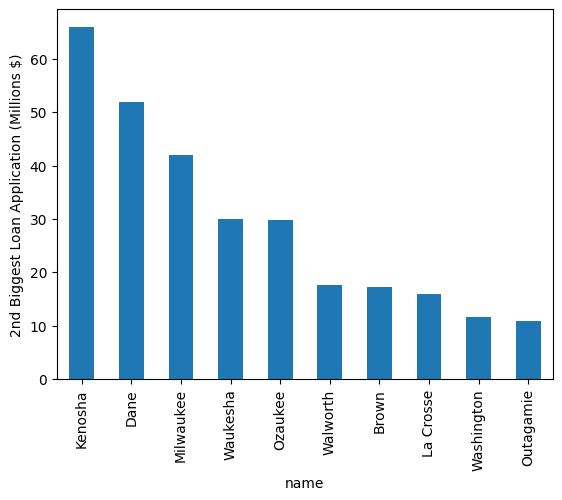

In [34]:
#q8
ax = q8.plot.bar(x="name", y="2nd Biggest Loan Application (Millions $)", legend = False)
ax.set_ylabel("2nd Biggest Loan Application (Millions $)")

### Q9: what is the cost of caching and the impact on subsequent queries?

In [35]:
df = spark.sql("""
SELECT interest_rate
FROM banks
INNER JOIN loans
ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
""")
df.unpersist()

DataFrame[interest_rate: string]

In [36]:
first = []
second= []
NotCached = []
Cached = []
isCached = False
for i in range(10):
    #caching in middle of loop
    if i == 5:
        df.cache()
        isCached = True
    
    #recording time it takes for query to run
    t0 = time.time()
    df.count()
    t1 = time.time()
    ms = (t1 - t0) * 1000
    
    #updating tracker
    if isCached:
        second.append(i)
        Cached.append(ms)
    else:
        first.append(i)
        NotCached.append(ms)

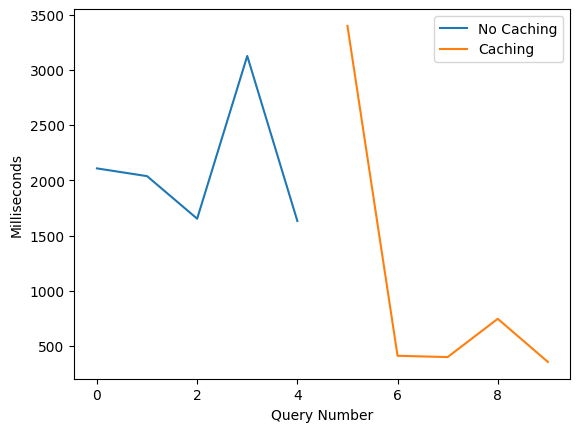

In [37]:
plt.plot(first, NotCached, label = "No Caching")
plt.plot(second, Cached, label = "Caching")
plt.xlabel("Query Number")
plt.ylabel("Milliseconds")
plt.legend()

### Q10: what is the impact of caching a single partition on load balance?

In [38]:
# https://spark.apache.org/docs/latest/monitoring.html#rest-api
# http://localhost:4040/api/v1/applications
# http://localhost:4040/api/v1/applications/{app_id}/executors
# look for "totalTasks"

r = requests.get("http://localhost:4040/api/v1/applications")
r.raise_for_status()
r = r.json()

In [39]:
# getting the app id
app_id = r[0]['id']
app_id

'app-20230403133449-0000'

In [40]:
df = df.repartition(1)
df.cache()

cTasks1 = []
cTasks2 = []

for i in range(10):
    df.count()
    req = requests.get(f"http://localhost:4040/api/v1/applications/{app_id}/executors")
    req.raise_for_status()
    req = req.json()
    cTasks1.append(req[1]["completedTasks"])
    cTasks2.append(req[2]["completedTasks"])
    
print(cTasks2)
print(cTasks1)

[58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
[53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


Text(0, 0.5, 'Task Count')

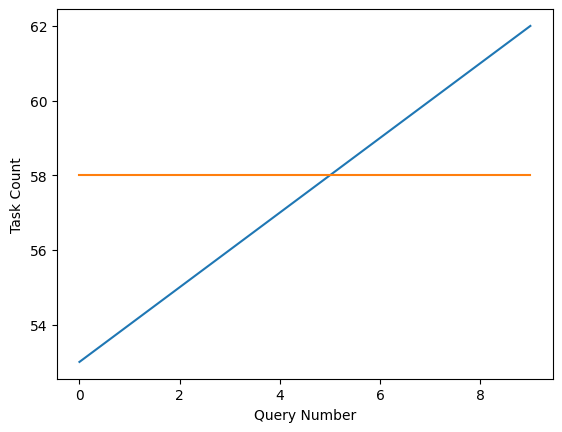

In [41]:
plt.plot(cTasks1)
plt.plot(cTasks2)
plt.xlabel("Query Number")
plt.ylabel("Task Count")